Notebook to develop the methods and algorithms that will produce the necessary modifications to PSF coefficients in order to handle changes in the WFE, either through OTE thermal/frill/IEC drifts, or field-dependent SI WFE 

In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

#from IPython.display import display, Latex, clear_output

In [2]:
# WebbPSF
import webbpsf

# Interpolation and extrapolation
from scipy.interpolate import griddata, RegularGridInterpolator
from scipy.ndimage import rotate

In [3]:
# pySIAF stuff for plotting
import pysiaf
from pysiaf.siaf import Siaf
from pysiaf.siaf import plot_main_apertures

siaf = Siaf('NIRCam')
siaf.generate_toc()

In [4]:
from astropy.table import Table

In [5]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import read_filter, gen_psf_coeff, gen_image_coeff
from pynrc.nrc_utils import gen_webbpsf_siwfe, field_coeff_resid, field_coeff_func
from pynrc.nrc_utils import Tel2Sci_info, NIRCam_V2V3_limits, radial_std
from pynrc.nrc_utils import jl_poly_fit, jl_poly

[     pynrc:INFO]   jwst_backgrounds is not installed and will not be used for bg estimates.


In [6]:
from pynrc.nrc_utils import frebin, dist_image, hist_indices, binned_statistic
from astropy.convolution import convolve, convolve_fft, Gaussian1DKernel, Gaussian2DKernel

def do_contrast(im1, im2, header, nsig=5, supersample=True, func=np.std):

    data = im1 - im2
    
    pixscale = header['PIXELSCL']
    oversample = header['OVERSAMP']
    rr, stds = radial_std(data, pixscale=pixscale, oversample=oversample, supersample=supersample, func=func)

    imavg = (im1+im2)/2
    if supersample or oversample==1:
        psf_max = imavg.max()
    else:
        psf_max = frebin(imavg, scale=1/oversample).max()

    return rr, nsig*stds/psf_max

import matplotlib.ticker as mticker
class MathTextSciFormatter(mticker.Formatter):
    def __init__(self, fmt="%.2e"):
        self.fmt = fmt
    def __call__(self, x, pos=None):
        s = self.fmt % x
        decimal_point = '.'
        positive_sign = '+'
        tup = s.split('e')
        significand = tup[0].rstrip(decimal_point)
        sign = tup[1][0].replace(positive_sign, '')
        exponent = tup[1][1:].lstrip('0')
        if exponent:
            exponent = '10^{%s%s}' % (sign, exponent)
        if significand and exponent:
            s =  r'%s{\times}%s' % (significand, exponent)
        else:
            s =  r'%s%s' % (significand, exponent)
        return "${}$".format(s)


# Setup for WebbPSF

In [7]:
# PSF setup
filter = 'F430M'
kwargs = {}
kwargs['pupil'] = None #'CIRCLYOT'

kwargs['force']     = True
kwargs['save']      = False
kwargs['save_name'] = None

bp = read_filter(filter)
channel = 'SW' if bp.avgwave() < 24000 else 'LW'
module = kwargs.get('module', 'A') # If not specified, choose 'A'
kwargs['module'] = module
# Check if coronagraphy
pupil = kwargs.get('pupil', 'CLEAR') # If not specified, choose 'A'
kwargs['pupil'] = pupil

kwargs['detector'] = None
kwargs['detector_position'] = None
kwargs['include_si_wfe'] = True

kwargs['use_legendre'] = True
fov_pix = kwargs['fov_pix'] = 127
oversample = kwargs['oversample'] = 4

kwargs['opd'] = ('OPD_RevW_ote_for_NIRCam_requirements.fits.gz', 0)
kwargs['jitter'] = 'gaussian'
kwargs['jitter_sigma'] = 0.007

apname = 'NRCA5_FULL'

In [8]:
kwargs

{'pupil': None,
 'force': True,
 'save': False,
 'save_name': None,
 'module': 'A',
 'detector': None,
 'detector_position': None,
 'include_si_wfe': True,
 'use_legendre': True,
 'fov_pix': 127,
 'oversample': 4,
 'opd': ('OPD_RevW_ote_for_NIRCam_requirements.fits.gz', 0),
 'jitter': 'gaussian',
 'jitter_sigma': 0.007}

# V2/V3 and Pixel locations

In [9]:
# SI Zernike data
if (pupil is not None) and ('LYOT' in pupil):
    zfile = 'si_zernikes_coron_wfe.fits'
else:
    zfile = 'si_zernikes_isim_cv3.fits'

data_dir = webbpsf.utils.get_webbpsf_data_path() + '/'
zernike_file = data_dir + zfile
ztable_full = Table.read(zernike_file)

mod = channel + module  
ind_nrc = ['NIRCam'+mod in row['instrument'] for row in ztable_full]  
ind_nrc = np.where(ind_nrc)

v2_all = np.array(ztable_full[ind_nrc]['V2'].tolist())
v3_all = np.array(ztable_full[ind_nrc]['V3'].tolist())

In [10]:
# WFE Drift Values
wfe_list = [0, 2, 5, 10]

# Do a subset, first 3 and last 3
# v2_all = np.append(v2_all[0:3], v2_all[-3:])
# v3_all = np.append(v3_all[0:3], v3_all[-3:])

v2_calc = v2_all[0:3]
v3_calc = v3_all[0:3]

ap = siaf[apname]

xvals = np.random.randint(0,2048,size=4)
yvals = np.random.randint(0,2048,size=4)

#xvals, yvals = np.array([800,1000]), np.array([1200,1000])
v2_calc, v3_calc = np.array(ap.sci_to_tel(xvals, yvals)) / 60

# pyNRC Timing

In [11]:
%%time
nrc = pynrc.NIRCam(filter=filter, use_legendre=True, include_si_wfe=True, apname=apname, 
                   fov_pix=fov_pix, oversample=oversample)

[     pynrc:INFO] Initializing SCA 485/A5
[     pynrc:INFO] Updating PSF coeff with fov_pix=257 and oversample=4
[     pynrc:INFO] Generating and saving new PSF coefficient
[     pynrc:INFO] Took 75.49 seconds to generate WebbPSF images
CPU times: user 4.73 s, sys: 2.48 s, total: 7.21 s
Wall time: 1min 19s


In [29]:
%%time
nrc.wfe_drift = True

[     pynrc:INFO] Updating PSF coeff with fov_pix=257 and oversample=4
[     pynrc:INFO] Calculating WFE Drift for fov_pix=257 and oversample=4


[     pynrc:WARNING] Generating WFE Drift coefficients. This may take some time...


[     pynrc:INFO] WFE Drift: 0 nm
[     pynrc:INFO] Generating but not saving new PSF coefficient
[     pynrc:INFO] Took 89.65 seconds to generate WebbPSF images
[     pynrc:INFO] WFE Drift: 1 nm
[     pynrc:INFO] Generating but not saving new PSF coefficient
[     pynrc:INFO] Took 73.03 seconds to generate WebbPSF images
[     pynrc:INFO] WFE Drift: 2 nm
[     pynrc:INFO] Generating but not saving new PSF coefficient
[     pynrc:INFO] Took 71.38 seconds to generate WebbPSF images
[     pynrc:INFO] WFE Drift: 5 nm
[     pynrc:INFO] Generating but not saving new PSF coefficient
[     pynrc:INFO] Took 67.30 seconds to generate WebbPSF images
[     pynrc:INFO] WFE Drift: 10 nm
[     pynrc:INFO] Generating but not saving new PSF coefficient
[     pynrc:INFO] Took 63.55 seconds to generate WebbPSF images
[     pynrc:INFO] WFE Drift: 20 nm
[     pynrc:INFO] Generating but not saving new PSF coefficient
[     pynrc:INFO] Took 61.99 seconds to generate WebbPSF images
[     pynrc:INFO] WFE Drif

In [30]:
%%time
nrc.wfe_field = True

# cf_fields_grid = nrc._psf_coeff_mod['si_field'] 
# v2grid  = nrc._psf_coeff_mod['si_field_v2grid'] 
# v3grid  = nrc._psf_coeff_mod['si_field_v3grid'] 

pyNRC log messages of level WARN and above will be shown.
pyNRC log outputs will be directed to the screen.


[     pynrc:WARNING] Generating field-dependent coefficients. This may take some time...
[     pynrc:WARNING] Interpolating coefficient residuals onto regular grid...
[     pynrc:WARNING] Done.


CPU times: user 5min 33s, sys: 59.8 s, total: 6min 32s
Wall time: 28min 56s


# Coefficient Plots

In [15]:
%%time
nrc = pynrc.NIRCam(filter=filter, use_legendre=True, include_si_wfe=True, apname=apname,
                   fov_pix=fov_pix, oversample=oversample)

[     pynrc:INFO] Initializing SCA 485/A5
[     pynrc:INFO] Updating PSF coeff with fov_pix=257 and oversample=4
CPU times: user 2.62 s, sys: 231 ms, total: 2.85 s
Wall time: 3.31 s


In [16]:
cf = nrc.psf_coeff
cf_hdr = nrc._psf_coeff_hdr

Text(0.5, 0, 'Coefficients')

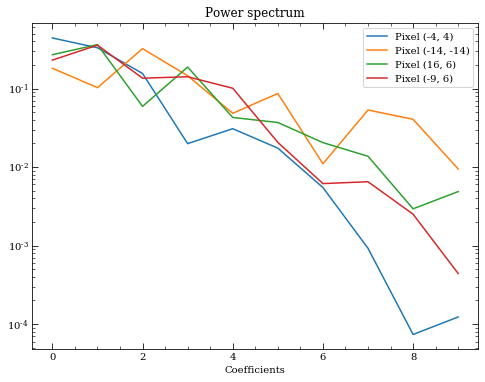

In [17]:
# varr = [(518,510), (500,500), (520,530), (520,505)]
varr = [(nx/2-4,ny/2+4), (nx/2-14,ny/2-14), (nx/2+16,ny/2+6), (nx/2-9,ny/2+6)]

for (xind, yind) in varr:
    xind, yind = int(xind), int(yind)
    vals = np.abs(cf[:,yind, xind])
    label='Pixel ({:.0f}, {:.0f})'.format((xind-nx/2), (yind-ny/2))
    plt.semilogy(vals / np.sum(vals), label=label)
    
plt.legend()
plt.title('Power spectrum')
plt.xlabel('Coefficients')

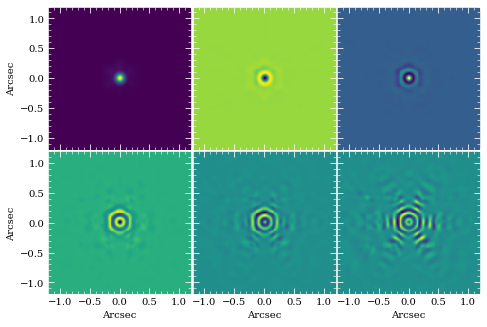

In [106]:
from matplotlib.colors import SymLogNorm, LogNorm

fig, axes = plt.subplots(2,3, figsize=(6,4), sharex=True, sharey=True)
axes = axes.flatten()

extent = 0.5 * np.array([-1,1,-1,1]) * fov_pix * nrc.pixelscale

xylim = np.array([-1,1]) * 1.2
for i in range(len(axes)):
    ax = axes[i]
    ax.imshow(cf[i], extent=extent)

    ax.set_xlim(xylim)
    ax.set_ylim(xylim)
    
    if i>2: ax.set_xlabel('Arcsec')
    if i % 3 == 0: ax.set_ylabel('Arcsec')

    ax.tick_params(axis='both', color='white', which='both')
    for k in ax.spines.keys():
        ax.spines[k].set_color('white')

    ax.xaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])
    ax.yaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])


fig.tight_layout()
fig.subplots_adjust(wspace=0.01, hspace=0.01, left=0, right=1, top=1, bottom=0)

# Demonstrate wavelength-dependent fits

In [84]:
inst = webbpsf.NIRCam()
inst.filter = filter
inst.SHORT_WAVELENGTH_MIN = inst.LONG_WAVELENGTH_MIN = 1e-7
inst.SHORT_WAVELENGTH_MAX = inst.LONG_WAVELENGTH_MAX = 10e-6

w1, w2 = (2.4,5.1)
ndeg = 9
dn = 20
npsf = np.ceil(dn * (w2-w1))
npsf = 5 if npsf<5 else int(npsf)
npsf = ndeg+1 if npsf<=ndeg else int(npsf)
waves = np.linspace(w1, w2, npsf)


[   webbpsf:INFO] NIRCam pixel scale switched to 0.063000 arcsec/pixel for the long wave channel.


In [ ]:
pynrc.setup_logging('WARN')

worker_arguments = [(inst, wlen, fov_pix, oversample) for wlen in waves]

hdu_arr = []
for wa in worker_arguments:
    hdu = nrc_utils._wrap_coeff_for_mp(wa)
    if hdu is None:
        raise RuntimeError('Returned None values. Issue with multiprocess or WebbPSF??')
    hdu_arr.append(hdu)

pynrc.setup_logging('INFO')

In [111]:
images = []
for hdu in hdu_arr:
    images.append(hdu.data)
images = np.array(images)

# Simultaneous polynomial fits to all pixels using linear least squares
coeff_all = jl_poly_fit(waves, images, deg=ndeg, use_legendre=True, lxmap=[w1,w2])

Text(0.5, 1.0, 'Example Pixel Fits')

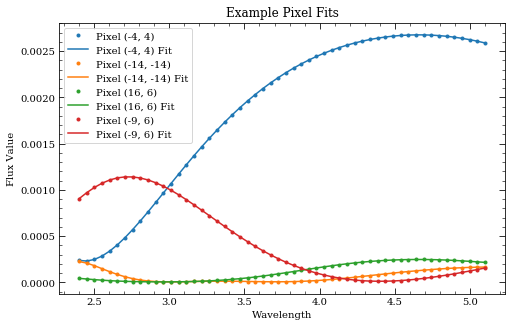

In [129]:
fig, ax = plt.subplots(1,1, figsize=(8,5))

# varr = [(518,510), (500,500), (520,530), (520,505)]
varr = [(nx/2-4,ny/2+4), (nx/2-14,ny/2-14), (nx/2+16,ny/2+6), (nx/2-9,ny/2+6)]

colarr = ['C0', 'C1', 'C2', 'C3']
for i, (xind, yind) in enumerate(varr):
    xind, yind = int(xind), int(yind)
        
    vals = images[:,yind,xind]
    label='Pixel ({:.0f}, {:.0f})'.format((xind-nx/2), (yind-ny/2))
    ax.plot(waves, vals, label=label, marker='.', ls='none', color=colarr[i])

    vals = jl_poly(waves, coeff_all[:,yind,xind], use_legendre=True, lxmap=[w1,w2])
    ax.plot(waves, vals, label=label+' Fit', color=colarr[i])
    
ax.legend()
ax.set_xlabel('Wavelength')
ax.set_ylabel('Flux Value')
ax.set_title('Example Pixel Fits')

# Field Coefficient Residuals

Text(0.5, 1.0, 'CV3 WFE Measurements - Module A')

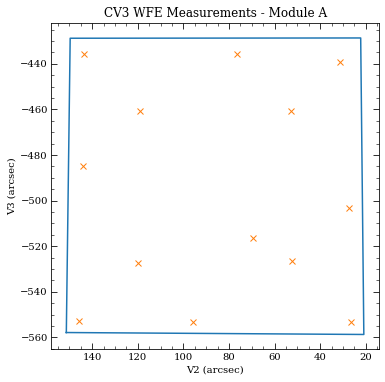

In [36]:
fig, ax = plt.subplots(1,1)

nrc.siaf_ap.plot(fill=False, ax=ax)
ax.plot(v2_all*60, v3_all*60, marker='x', ls='none')

ax.set_title('CV3 WFE Measurements - Module A')

In [11]:
pynrc.setup_logging('WARN')

pyNRC log messages of level WARN and above will be shown.
pyNRC log outputs will be directed to the screen.


In [12]:
%%time
nrc = pynrc.NIRCam(filter=filter, use_legendre=True, include_si_wfe=True, apname=apname,
                   fov_pix=fov_pix, oversample=oversample)

CPU times: user 2.13 s, sys: 95.7 ms, total: 2.23 s
Wall time: 2.22 s


In [13]:
%%time
nrc.wfe_drift = True
nrc.wfe_field = True

CPU times: user 11.7 s, sys: 1.12 s, total: 12.8 s
Wall time: 12.7 s


In [14]:
from pynrc.nrc_utils import field_coeff_func

cf_fit = nrc._psf_coeff_mod['si_field'] 
v2grid  = nrc._psf_coeff_mod['si_field_v2grid'] 
v3grid  = nrc._psf_coeff_mod['si_field_v3grid'] 

res = field_coeff_func(v2grid, v3grid, cf_fit, 2, -8)

In [15]:
cf_fit.shape

(8, 8, 10, 508, 508)

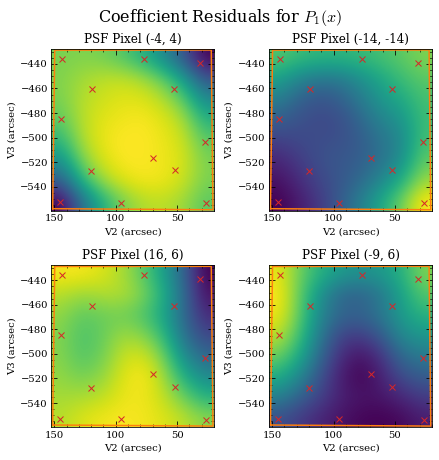

In [19]:
fig, axes = plt.subplots(2,2, figsize=(6.2,6.5))
axes = axes.flatten()

ny, nx = cf_fit.shape[3:]
varr = [(nx/2-4,ny/2+4), (nx/2-14,ny/2-14), (nx/2+16,ny/2+6), (nx/2-9,ny/2+6)]

extent = np.array([v2grid.min(), v2grid.max(), v3grid.min(), v3grid.max()]) * 60
for i, (xind,yind) in enumerate(varr):
    ax = axes[i]
    xind, yind = int(xind), int(yind)
    ax.imshow(cf_fit[:,:,1,yind, xind], extent=extent, interpolation='bicubic')

    nrc.siaf_ap.plot(fill=False, ax=ax, color='C1')
    ax.plot(v2_all*60, v3_all*60, marker='x', ls='none', color='C3')
    
    ax.set_title('PSF Pixel ({:.0f}, {:.0f})'.format(xind-nx/2,yind-ny/2))
    
fig.suptitle('Coefficient Residuals for $P_{1}(x)$', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.9)

## WebbPSF Intrinsic PSFs

In [20]:
v23_0 = np.array(ap.sci_to_tel(1024, 1024)) / 60
%time hdul0 = gen_webbpsf_siwfe(filter, v23_0, wfe_drift=0, **kwargs)

NRCA5 (1024.0015941979366, 1023.9931974179896) NRCA5_FULL
CPU times: user 11.2 s, sys: 1.67 s, total: 12.9 s
Wall time: 20.8 s


In [177]:
psf0_dict = {}
for wfe in wfe_list:
    hdul = gen_webbpsf_siwfe(filter, v23_0, wfe_drift=wfe, **kwargs)
    k_wfe = 'wfe_{:.0f}nm'.format(wfe)
    psf0_dict[k_wfe] = hdul

NRCA5 (1024.0015941979366, 1023.9931974179896) NRCA5_FULL
NRCA5 (1024.0015941979366, 1023.9931974179896) NRCA5_FULL
NRCA5 (1024.0015941979366, 1023.9931974179896) NRCA5_FULL
NRCA5 (1024.0015941979366, 1023.9931974179896) NRCA5_FULL


In [21]:
pynrc.setup_logging('WARN', verbose=False)

psf_dict = {}
for (v2, v3) in zip(v2_calc, v3_calc):
    print(v2,v3)
    d = {}
    for wfe in wfe_list:
        hdul = gen_webbpsf_siwfe(filter, (v2,v3), wfe_drift=wfe, **kwargs)
        k_wfe = 'wfe_{:.0f}nm'.format(wfe)
        d[k_wfe] = hdul

    k_si = 'V2V3_({:.2f},{:.2f})'.format(v2,v3) 
    psf_dict[k_si] = d

0.4095213734637278 -7.2110691137459355
NRCA5 (2010.0100348769931, 1984.985775339274) NRCA5_FULL
NRCA5 (2010.0100348769931, 1984.985775339274) NRCA5_FULL
NRCA5 (2010.0100348769931, 1984.985775339274) NRCA5_FULL
NRCA5 (2010.0100348769931, 1984.985775339274) NRCA5_FULL
2.1364655337529066 -7.361552995574049
NRCA5 (346.9788348783734, 1845.0126156606143) NRCA5_FULL
NRCA5 (346.9788348783734, 1845.0126156606143) NRCA5_FULL
NRCA5 (346.9788348783734, 1845.0126156606143) NRCA5_FULL
NRCA5 (346.9788348783734, 1845.0126156606143) NRCA5_FULL
1.9221248308655006 -9.122905261348823
NRCA5 (565.01296539909, 170.99287354099977) NRCA5_FULL
NRCA5 (565.01296539909, 170.99287354099977) NRCA5_FULL
NRCA5 (565.01296539909, 170.99287354099977) NRCA5_FULL
NRCA5 (565.01296539909, 170.99287354099977) NRCA5_FULL
0.4695544697116382 -8.731767317838662
NRCA5 (1938.9864803246421, 543.0077618099481) NRCA5_FULL
NRCA5 (1938.9864803246421, 543.0077618099481) NRCA5_FULL
NRCA5 (1938.9864803246421, 543.0077618099481) NRCA5_FULL


In [13]:
# i1, i2 = (0,1) # PSF postions
# j1, j2 = (0,0) # WFE drifts

# keys1 = list(psf_dict.keys())
# d1 = psf_dict[keys1[i1]]
# d2 = psf_dict[keys1[i2]]

# keys2 = list(d1.keys())
# hdul1 = d1[keys2[j1]]
# hdul2 = d2[keys2[j2]]

# print(keys1[i1], keys2[j1])
# print(keys1[i2], keys2[j2])

# print(hdul1[1].data.sum(), hdul2[1].data.sum())

## SI WFE PSF Comparisons

In [22]:
%%time
psf0, psf0_over = nrc.gen_psf(wfe_drift=0, coord_vals=(1024,1024), coord_frame='sci', 
                              return_oversample=True)

1.4345073352416666 -8.223619268481665
CPU times: user 686 ms, sys: 285 ms, total: 971 ms
Wall time: 839 ms


In [205]:
%%time
psf_list = []
psf_over_list = []
for (v2, v3) in zip(v2_calc, v3_calc):
    psf, psf_over = nrc.gen_psf(wfe_drift=0, coord_vals=(v2,v3), coord_frame='tel', 
                              return_oversample=True)
    psf_list.append(psf)
    psf_over_list.append(psf_over)

0.4095213734637278 -7.2110691137459355
2.1364655337529066 -7.361552995574049
1.9221248308655006 -9.122905261348823
0.4695544697116382 -8.731767317838662
CPU times: user 3.22 s, sys: 1.19 s, total: 4.41 s
Wall time: 3.8 s


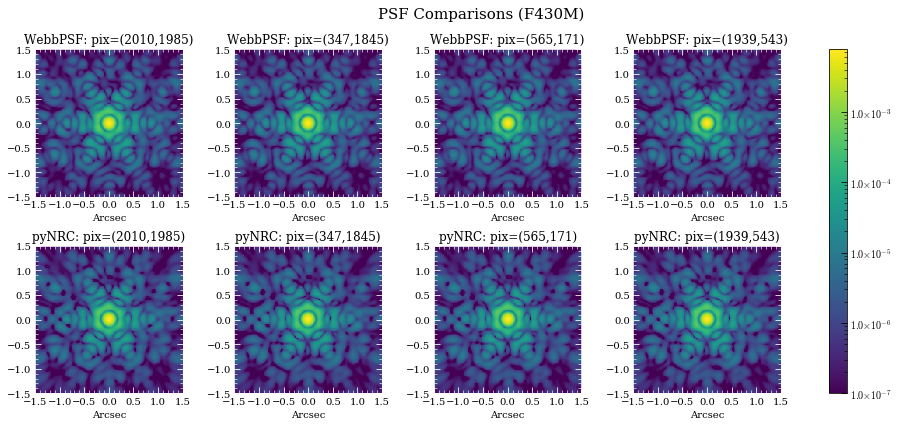

In [26]:
from matplotlib.colors import SymLogNorm, LogNorm

fig, axes = plt.subplots(2,4,figsize=(14,6))

im_list = [psf_dict[k]['wfe_0nm'][0].data for k in psf_dict.keys()]

extent = 0.5 * np.array([-1,1,-1,1]) * fov_pix * nrc.pixelscale

for i, im in enumerate(im_list):
    ax = axes[0,i]
    pos = ax.imshow(im, extent=extent, norm=LogNorm(vmin=1e-7))
    ax.set_title('WebbPSF: pix=({:.0f},{:.0f})'.format(xvals[i],yvals[i]))
for i, im in enumerate(psf_over_list):
    ax = axes[1,i]
    pos = ax.imshow(im, extent=extent, norm=LogNorm(vmin=1e-7))
    ax.set_title('pyNRC: pix=({:.0f},{:.0f})'.format(xvals[i],yvals[i]))
    
xylim = np.array([-1,1]) * 1.5
for i, ax in enumerate(axes.flatten()):
    ax.set_xlim(xylim)
    ax.set_ylim(xylim)
    
    if i>3: ax.set_xlabel('Arcsec')
    if i % 4 == 0: ax.set_ylabel('Arcsec')

    ax.tick_params(axis='both', color='white', which='both')
    for k in ax.spines.keys():
        ax.spines[k].set_color('white')

    ax.xaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])
    ax.yaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])
    
fig.suptitle('PSF Comparisons ({})'.format(nrc.filter), fontsize=15)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

cb = fig.colorbar(pos, ax=axes.ravel().tolist())
cb.ax.yaxis.set_major_formatter(MathTextSciFormatter("%.1e"))


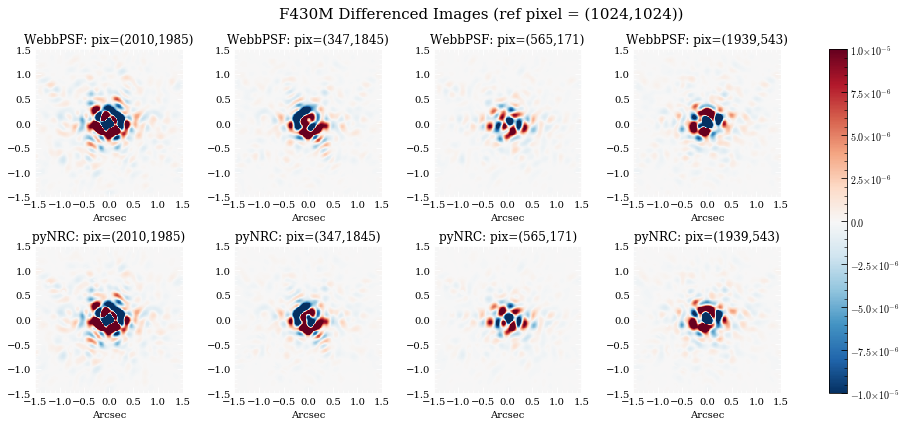

In [27]:
from matplotlib.colors import SymLogNorm, LogNorm

fig, axes = plt.subplots(2,4,figsize=(14,6))

im_list = [psf_dict[k]['wfe_0nm'][0].data for k in psf_dict.keys()]

extent = 0.5 * np.array([-1,1,-1,1]) * fov_pix * nrc.pixelscale

vmin, vmax = np.array([-1,1])*1e-5

vlevels_list = []
for i, im in enumerate(im_list):
    ax = axes[0,i]
    diff = im - hdul0[0].data
    
#     vmin, vmax = np.array([-1,1]) * np.mean(np.abs([diff.min(),diff.max()])) / 2
    vlevels_list.append((vmin,vmax))
    
    pos = ax.imshow(diff, extent=extent, vmin=vmin, vmax=vmax, cmap='RdBu_r')
    ax.set_title('WebbPSF: pix=({:.0f},{:.0f})'.format(xvals[i],yvals[i]))
#     fig.colorbar(pos, ax=ax, format='%.1e')
    
for i, im in enumerate(psf_over_list):
    ax = axes[1,i]
    diff = im - psf0_over
    
#     vmin, vmax = vlevels_list[i]
    pos = ax.imshow(diff, extent=extent, vmin=vmin, vmax=vmax, cmap='RdBu_r')
    ax.set_title('pyNRC: pix=({:.0f},{:.0f})'.format(xvals[i],yvals[i]))
#     fig.colorbar(pos, ax=ax, format='%.1e')
    
xylim = np.array([-1,1]) * 1.5
for i, ax in enumerate(axes.flatten()):
    ax.set_xlim(xylim)
    ax.set_ylim(xylim)
    
    if i>3: ax.set_xlabel('Arcsec')
    if i % 4 == 0: ax.set_ylabel('Arcsec')

    ax.tick_params(axis='both', color='white', which='both')
    for k in ax.spines.keys():
        ax.spines[k].set_color('white')

    ax.xaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])
    ax.yaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])

    
fig.suptitle('{} Differenced Images (ref pixel = (1024,1024))'.format(nrc.filter), fontsize=15)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

cb = fig.colorbar(pos, ax=axes.ravel().tolist())
cb.ax.yaxis.set_major_formatter(MathTextSciFormatter("%.1e"))


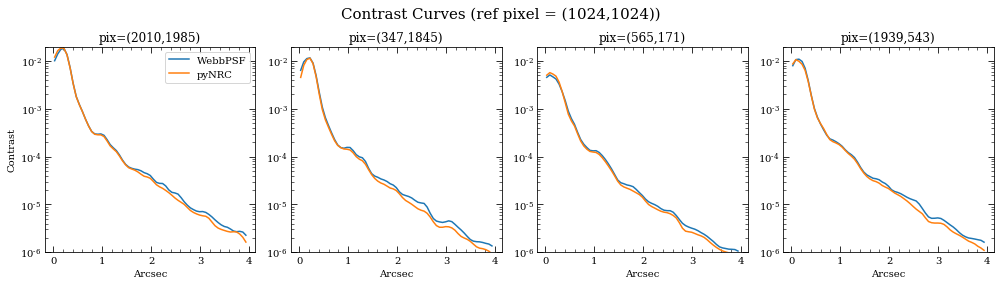

In [207]:
fig, axes = plt.subplots(1,4,figsize=(14,4))

im_list = [psf_dict[k]['wfe_0nm'][0].data for k in psf_dict.keys()]

header = hdul0[0].header
for i, im in enumerate(im_list):
    ax = axes[i]
    diff = im - hdul0[0].data
    
    rr, cont = do_contrast(im, hdul0[0].data, header, nsig=5, supersample=False, func=robust.std)
    ax.semilogy(rr, cont, label='WebbPSF')
    
    ax.set_title('pix=({:.0f},{:.0f})'.format(xvals[i],yvals[i]))

for i, im in enumerate(psf_over_list):
    ax = axes[i]
    diff = im - hdul0[0].data
    
    rr, cont = do_contrast(im, psf0_over, header, nsig=5, supersample=False, func=robust.std)
    ax.semilogy(rr, cont, label='pyNRC')

    
axes[0].set_ylabel('Contrast')
axes[0].legend()
for ax in axes:
    ax.set_ylim([1e-6,2e-2])
    ax.set_xlabel('Arcsec')

fig.suptitle('Contrast Curves (ref pixel = (1024,1024))', fontsize=15)
fig.tight_layout()
fig.subplots_adjust(top=0.84)

## WFE Drift Coefficients

In [50]:
kwargs

{'pupil': None,
 'force': True,
 'save': False,
 'save_name': None,
 'module': 'A',
 'detector': None,
 'detector_position': None,
 'include_si_wfe': True,
 'use_legendre': True,
 'fov_pix': 127,
 'oversample': 4,
 'opd': ('OPD_RevW_ote_for_NIRCam_requirements.fits.gz', 0),
 'jitter': 'gaussian',
 'jitter_sigma': 0.007}

In [55]:
# Cycle through WFE drifts for fitting
wfe_list = np.array([0,1,2,5,10,20,30,40])
nwfe = len(wfe_list)

cf_wfe = []
for wfe in wfe_list:
    print('WFE Drift: {} nm'.format(wfe))
    cf, _ = gen_psf_coeff(nrc.bandpass, wfe_drift=wfe, **kwargs)
    cf_wfe.append(cf)

cf_wfe = np.array(cf_wfe)

# Get residuals
cf_wfe = cf_wfe - cf_wfe[0]


WFE Drift: 0 nm
WFE Drift: 1 nm
WFE Drift: 2 nm
WFE Drift: 5 nm
WFE Drift: 10 nm
WFE Drift: 20 nm
WFE Drift: 30 nm
WFE Drift: 40 nm


In [30]:
cf_resid = nrc._psf_coeff_mod['wfe_drift']
lxmap = nrc._psf_coeff_mod['wfe_drift_lxmap']

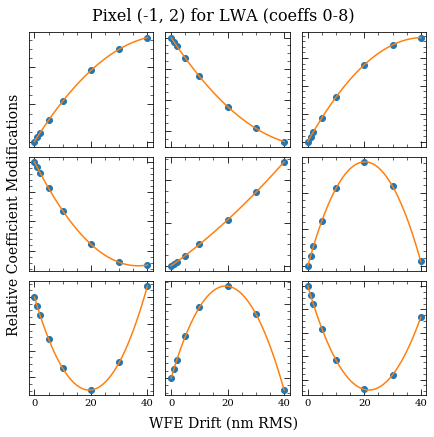

In [96]:
fig, axes = plt.subplots(3,3, figsize=(6,6))

indy, indx = int(ny/2+2),int(nx/2-1)

for i, ax in enumerate(axes.flatten()):
    cf = cf_resid[:,i, indy,indx]

    wfe_arr = np.array([0,1,2,5,10,20,40])
    cf_vals = jl_poly(wfe_arr, cf, use_legendre=True, lxmap=lxmap)
#     ax.plot(wfe_arr, cf_vals, ls='none', marker='o')
    ax.plot(wfe_list, cf_wfe[:,i,indy,indx], ls='none', marker='o')

    wfe_arr = np.arange(0,41)
    cf_vals = jl_poly(wfe_arr, cf, use_legendre=True, lxmap=lxmap)
    ax.plot(wfe_arr, cf_vals)
    
    labels = [item.get_text() for item in ax.get_yticklabels()]
    empty_string_labels = ['']*len(labels)
    ax.set_yticklabels(empty_string_labels)

    labels = [item.get_text() for item in ax.get_xticklabels()]
    empty_string_labels = ['']*len(labels)
    if i<6: ax.set_xticklabels(empty_string_labels)
        

fig.text(0.5, 0., 'WFE Drift (nm RMS)', ha='center', va='bottom', fontsize=14)
fig.text(0., 0.5, 'Relative Coefficient Modifications', va='center', ha='left', fontsize=14, rotation=90)
txt = 'Pixel ({:.0f}, {:.0f}) for LWA (coeffs 0-8)'.format(indx-nx/2,indy-nx/2)
fig.suptitle(txt, fontsize=16)

fig.tight_layout()
fig.subplots_adjust(bottom=0.08, left=0.05, top=0.92)


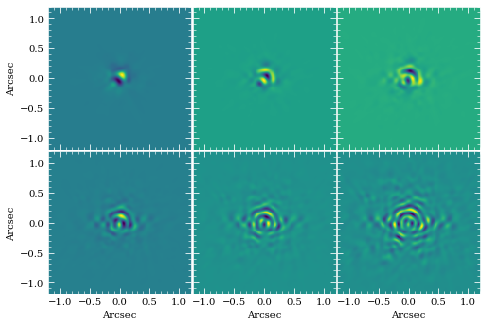

In [115]:
from matplotlib.colors import SymLogNorm, LogNorm

fig, axes = plt.subplots(2,3, figsize=(6,4), sharex=True, sharey=True)
axes = axes.flatten()

extent = 0.5 * np.array([-1,1,-1,1]) * fov_pix * nrc.pixelscale

xylim = np.array([-1,1]) * 1.2
for i in range(len(axes)):
    ax = axes[i]
    ax.imshow(cf_resid[1,i,:,:], extent=extent)

    ax.set_xlim(xylim)
    ax.set_ylim(xylim)
    
    if i>2: ax.set_xlabel('Arcsec')
    if i % 3 == 0: ax.set_ylabel('Arcsec')

    ax.tick_params(axis='both', color='white', which='both')
    for k in ax.spines.keys():
        ax.spines[k].set_color('white')

    ax.xaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])
    ax.yaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])


fig.tight_layout()
fig.subplots_adjust(wspace=0.01, hspace=0.01, left=0, right=1, top=1, bottom=0)

## WFE Drift PSF Comparisons

In [142]:
keys_v2v3 = list(psf_dict.keys())
keys_wfed = list(psf_dict[keys_v2v3[0]].keys())
print(keys_v2v3)
print(keys_wfed)

['V2V3_(0.41,-7.21)', 'V2V3_(2.14,-7.36)', 'V2V3_(1.92,-9.12)', 'V2V3_(0.47,-8.73)']
['wfe_0nm', 'wfe_2nm', 'wfe_5nm', 'wfe_10nm']


In [139]:
wfe_list = [0, 2, 5, 10]

In [210]:
%%time
psf_list = []
psf_over_list = []

for wfed in wfe_list:
    psf, psf_over = nrc.gen_psf(wfe_drift=wfed, coord_vals=(1024,1024), coord_frame='sci', 
                              return_oversample=True)
    psf_list.append(psf)
    psf_over_list.append(psf_over)

1.4345073352416666 -8.223619268481665
1.4345073352416666 -8.223619268481665
1.4345073352416666 -8.223619268481665
1.4345073352416666 -8.223619268481665
CPU times: user 3.2 s, sys: 1.16 s, total: 4.36 s
Wall time: 3.99 s


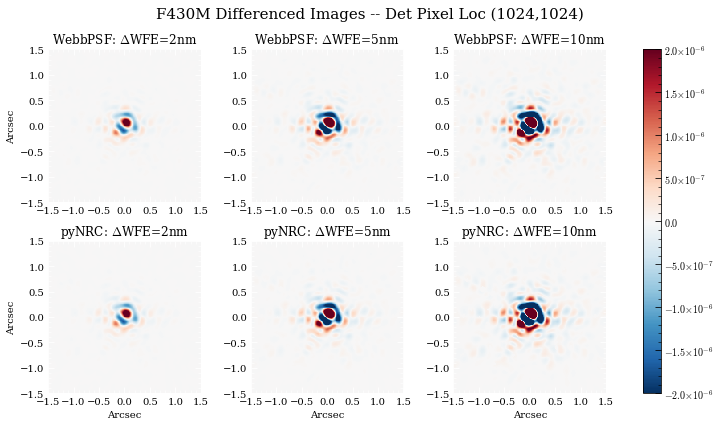

In [200]:
from matplotlib.colors import SymLogNorm, LogNorm

fig, axes = plt.subplots(2,3,figsize=(11,6))

im_list = [psf0_dict[k][0].data for k in keys_wfed]

extent = 0.5 * np.array([-1,1,-1,1]) * fov_pix * nrc.pixelscale
vmin, vmax = np.array([-1,1])*2e-6

vlevels_list = []
for i, im in enumerate(im_list):
    if i==0:
        pass
    ax = axes[0,i-1]
    diff = im - im_list[0]
    
    vlevels_list.append((vmin,vmax))
    
    pos = ax.imshow(diff, extent=extent, vmin=vmin, vmax=vmax, cmap='RdBu_r')
    ax.set_title('WebbPSF: $\Delta$WFE={}nm'.format(wfe_list[i]))
    
for i, im in enumerate(psf_over_list):
    if i==0:
        pass
    ax = axes[1,i-1]
    diff = im - psf_over_list[0]
    
    pos = ax.imshow(diff, extent=extent, vmin=vmin, vmax=vmax, cmap='RdBu_r')
    ax.set_title('pyNRC: $\Delta$WFE={}nm'.format(wfe_list[i]))
    
xylim = np.array([-1,1]) * 1.5
for i, ax in enumerate(axes.flatten()):
    ax.set_xlim(xylim)
    ax.set_ylim(xylim)
    
    if i>2: ax.set_xlabel('Arcsec')
    if i % 3 == 0: ax.set_ylabel('Arcsec')

    ax.tick_params(axis='both', color='white', which='both')
    for k in ax.spines.keys():
        ax.spines[k].set_color('white')

    ax.xaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])
    ax.yaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])

    
fig.suptitle('{} Differenced Images -- Det Pixel Loc (1024,1024)'.format(nrc.filter), fontsize=15)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

cb = fig.colorbar(pos, ax=axes.ravel().tolist())
cb.ax.yaxis.set_major_formatter(MathTextSciFormatter("%.1e"))


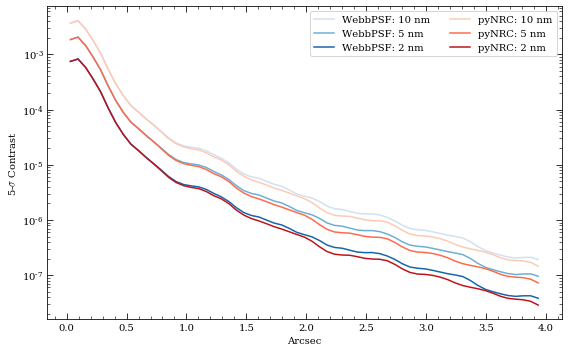

In [217]:
from pynrc import robust

fig, ax = plt.subplots(1,1, figsize=(8,5))

lin_vals = np.linspace(0.2,0.8,len(wfe_list)-1)
c1 = plt.cm.Blues_r(lin_vals)[::-1]
c2 = plt.cm.Reds_r(lin_vals)[::-1]


im_list = [psf0_dict[k][0].data for k in keys_wfed]

wfe_rev = wfe_list[1:][::-1]
im_list_rev = im_list[1:][::-1]
for i, im in enumerate(im_list_rev):
    rr, cont = do_contrast(im, im_list[0], header, nsig=5, supersample=False, func=robust.std)
    ax.semilogy(rr, cont, color=c1[i], label='WebbPSF: {} nm'.format(wfe_rev[i]))

im_list_rev = psf_over_list[1:][::-1]
for i, im in enumerate(im_list_rev):
    rr, cont = do_contrast(im, psf_over_list[0], header, nsig=5, supersample=False, func=robust.std)
    ax.semilogy(rr, cont, color=c2[i], label='pyNRC: {} nm'.format(wfe_rev[i]))

ax.legend(ncol=2)
ax.set_xlabel('Arcsec')
ax.set_ylabel('5-$\sigma$ Contrast')

fig.tight_layout()

# Compare WFE field and WFE drift

In [ ]:
# Plot field contrast curves as a function of distance.
# Plot contrast at 1"

In [225]:
sep_asec = np.array([1,2,5,10,20,30,60])

v2_arr = np.ones([4,len(sep_asec)]) * v23_0[0]
v3_arr = np.ones([4,len(sep_asec)]) * v23_0[1]

v2_arr[0] -= sep_asec/60
v2_arr[1] += sep_asec/60

v3_arr[2] -= sep_asec/60
v3_arr[3] += sep_asec/60

In [229]:
psf0, psf0_over = nrc.gen_psf(wfe_drift=0, coord_vals=(v23_0[0],v23_0[1]), coord_frame='tel', 
                              return_oversample=True)

1.4345073352416666 -8.223619268481665


In [245]:
# Field Dependent PSFs
psf_over_list = []
for (v2, v3) in zip(v2_arr.flatten(), v3_arr.flatten()):
    _, psf_over = nrc.gen_psf(wfe_drift=0, coord_vals=(v2,v3), coord_frame='tel', 
                                return_oversample=True)
    psf_over_list.append(psf_over)

1.417840668575 -8.223619268481665
1.4011740019083332 -8.223619268481665
1.3511740019083334 -8.223619268481665
1.2678406685749999 -8.223619268481665
1.1011740019083334 -8.223619268481665
0.9345073352416666 -8.223619268481665
0.4345073352416666 -8.223619268481665
1.4511740019083332 -8.223619268481665
1.467840668575 -8.223619268481665
1.5178406685749999 -8.223619268481665
1.6011740019083334 -8.223619268481665
1.7678406685749999 -8.223619268481665
1.9345073352416666 -8.223619268481665
2.4345073352416664 -8.223619268481665
1.4345073352416666 -8.240285935148332
1.4345073352416666 -8.256952601814998
1.4345073352416666 -8.306952601814999
1.4345073352416666 -8.39028593514833
1.4345073352416666 -8.556952601814999
1.4345073352416666 -8.723619268481665
1.4345073352416666 -9.223619268481665
1.4345073352416666 -8.206952601814997
1.4345073352416666 -8.190285935148331
1.4345073352416666 -8.14028593514833
1.4345073352416666 -8.056952601814999
1.4345073352416666 -7.890285935148332
1.4345073352416666 -7.

In [258]:
# WFE Drift PSFs
wfe_list = [1,2,5,10]
psf_over_list2 = []
for wfed in wfe_list:
    _, psf_over = nrc.gen_psf(wfe_drift=wfed, coord_vals=(1024,1024), coord_frame='sci', 
                                return_oversample=True)
    psf_over_list2.append(psf_over)

1.4345073352416666 -8.223619268481665
1.4345073352416666 -8.223619268481665
1.4345073352416666 -8.223619268481665
1.4345073352416666 -8.223619268481665


In [282]:
# Field Contrasts
cont_arr = []
for im in psf_over_list:

    rr, cont = do_contrast(im, psf0_over, header, nsig=5, supersample=False, func=np.std)
    cont_arr.append(cont)

cont_arr = np.array(cont_arr).reshape([4,len(sep_asec),-1])
cont_med = np.mean(cont_arr, axis=0)


# WFE Drift Contrasts
cont_arr2 = []
for im in psf_over_list2:

    rr, cont = do_contrast(im, psf0_over, header, nsig=5, supersample=False, func=np.std)
    cont_arr2.append(cont)

cont_arr2 = np.array(cont_arr2)

In [283]:
print(cont_arr.shape, cont_med.shape, cont_arr2.shape)

(4, 7, 63) (7, 63) (4, 63)


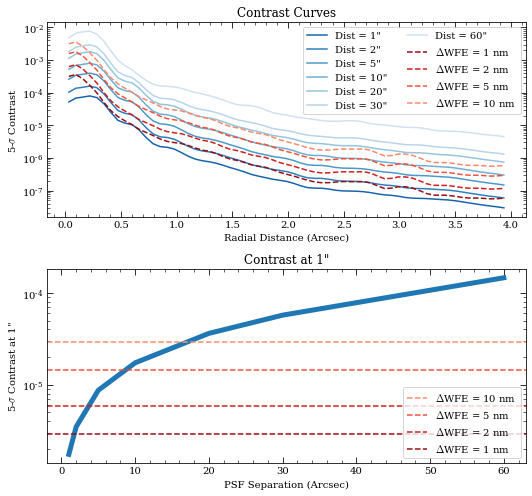

In [307]:
fig, axes = plt.subplots(2,1, figsize=(7.5,7))

lin_vals = np.linspace(0.2,0.8,cont_med.shape[0])
c1 = plt.cm.Blues_r(lin_vals)
lin_vals = np.linspace(0.1,0.6,len(wfe_list))
c2 = plt.cm.Reds_r(lin_vals)

ax = axes[0]
for i, cont in enumerate(cont_med):
    ax.semilogy(rr, cont, color=c1[i], label='Dist = {}"'.format(sep_asec[i]))

for i, cont in enumerate(cont_arr2):
    ax.semilogy(rr, cont, color=c2[i], label='$\Delta$WFE = {} nm'.format(wfe_list[i]), ls='--')

ax.legend(ncol=2)
ax.set_xlabel('Radial Distance (Arcsec)')
ax.set_ylabel('5-$\sigma$ Contrast')
ax.set_title('Contrast Curves')



ax = axes[1]
vals = np.array([np.interp(1, rr, cont) for cont in cont_med])
ax.semilogy(sep_asec, vals, lw=5)

xlim = ax.get_xlim()
for i, cont in enumerate(cont_arr2[::-1]):
    xvals = xlim
    yvals = np.interp(1,rr,cont) * np.array([1,1])
    label='$\Delta$WFE = {} nm'.format(wfe_list[::-1][i])
    ax.plot(xvals, yvals, color=c2[::-1][i], label=label, ls='--')

ax.set_xlim(xlim)
ax.set_xlabel('PSF Separation (Arcsec)')
ax.set_ylabel('5-$\sigma$ Contrast at 1"')
ax.set_title('Contrast at 1"')
ax.legend(loc='lower right')

fig.tight_layout()
fig.savefig('contrast_compare.pdf')

# Old Stuff

In [16]:
xvals = np.random.randint(0,2048,size=1)
yvals = np.random.randint(0,2048,size=1)
v2, v3 = np.array(ap.sci_to_tel(xvals, yvals)) / 60
pts = np.array([v2,v3]).transpose()

cf_fit = nrc._psf_coeff_mod['si_field'] 
v2grid  = nrc._psf_coeff_mod['si_field_v2grid'] 
v3grid  = nrc._psf_coeff_mod['si_field_v3grid'] 

%time cf_resid = field_coeff_func(v2grid, v3grid, cf_fit, v2, v3)

CPU times: user 52 ms, sys: 10.4 ms, total: 62.3 ms
Wall time: 79.1 ms


In [17]:
%time cf_new  = nrc._psf_coeff + cf_resid
psf_coeff_hdr = nrc._psf_coeff_hdr
psf_info      = nrc._psf_info

CPU times: user 7.38 ms, sys: 2.05 ms, total: 9.44 ms
Wall time: 7.11 ms


In [41]:
bp = nrc.bandpass
waveset = np.copy(bp.wave)
binsize = 3

excess = waveset.size % binsize
waveset = waveset[:waveset.size-excess]
waveset = waveset.reshape(-1,binsize) # Reshape
waveset = waveset[:,binsize//2] # Use the middle values
waveset = np.concatenate(([bp.wave[0]],waveset,[bp.wave[-1]]))

wgood = waveset / 1e4
w1 = wgood.min()
w2 = wgood.max()
wrange = w2 - w1

use_legendre = True if psf_coeff_hdr['LEGNDR'] else False
lxmap = [psf_coeff_hdr['WAVE1'], psf_coeff_hdr['WAVE2']]
%time psf_fit = nrc_utils.jl_poly(wgood, cf_new, dim_reorder=True, use_legendre=use_legendre, lxmap=lxmap)
#%time psf_fit[psf_fit<=0] = np.min(psf_fit[psf_fit>0]) / 10

CPU times: user 351 ms, sys: 212 ms, total: 563 ms
Wall time: 518 ms


In [28]:
psf_fit.shape

(356, 508, 508)

In [22]:
from pynrc.nrc_utils import S

In [33]:
sp_flat = S.ArraySpectrum(waveset, 0*waveset + 10.)
sp_norm = sp_flat.renorm(bp.unit_response(), 'flam', bp)
sp_norm = [sp_norm]
obs_list = [S.Observation(sp, bp, binset=waveset) for sp in sp_norm]

In [34]:
obs_list[0].binflux.shape

(356,)

In [31]:
psf_temp = psf_fit.reshape([356,-1])

In [36]:
%time test = psf_temp * obs_list[0].binflux.reshape([-1,1])

CPU times: user 212 ms, sys: 194 ms, total: 406 ms
Wall time: 414 ms


In [40]:
psf_list = []
psf_temp = psf_fit.reshape([356,-1])
for obs in obs_list:
    psf_list.appen(psf_temp)

CPU times: user 5.33 s, sys: 22.3 ms, total: 5.35 s
Wall time: 5.4 s


In [42]:
%time psf_list = [psf_fit*obs.binflux for obs in obs_list]

CPU times: user 227 ms, sys: 280 ms, total: 507 ms
Wall time: 524 ms


In [80]:
test = psf_fit[:,:,3]
len(test[test<0])

9728

In [83]:
%time fin = nrc_utils.krebin(data_over, (257,257))

CPU times: user 7.47 ms, sys: 1.46 ms, total: 8.92 ms
Wall time: 7.7 ms


In [81]:
data_over = psf_fit.sum(axis=2)
data_over[data_over<=0]

array([-1.42025982e-05, -2.12730559e-05, -9.43610743e-06, -2.22144758e-05,
       -2.44904022e-05, -6.85660957e-06])

In [69]:
data_over.shape

(1028, 1028)

In [65]:
len(ind)

5737122

In [45]:
%%time
psf = gen_image_coeff(nrc.bandpass, 
                    coeff=cf_new, coeff_hdr=psf_coeff_hdr, 
                    fov_pix=psf_info['fov_pix'], oversample=psf_info['oversample'],
                    return_oversample=False)

CPU times: user 3.75 s, sys: 4.11 s, total: 7.85 s
Wall time: 9.78 s


In [194]:
coeff, head = nrc_utils.gen_psf_coeff('F444W', fov_pix=fov_pix, oversample=oversample, quick=True, save=False, force=True, 
                                      use_legendre=True, ndeg=11)

In [199]:
print(head['NPSF'], head['NDEG'])
lxmap = [head['WAVE1'], head['WAVE2']]
test = nrc_utils.jl_poly(np.array([4.4]), coeff, dim_reorder=True, use_legendre=True, lxmap=lxmap)
test[test<=0] = np.min(test[test>0])

29 11


In [200]:
print(test.min(), test.sum())

1.1149215835276275e-13 0.9802171583373691


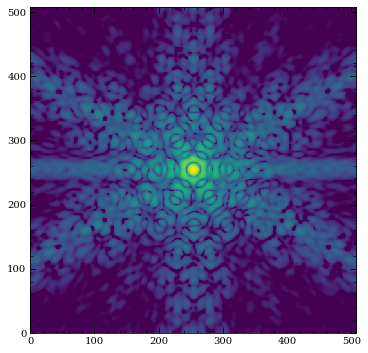

In [201]:
plt.imshow(test[:,:,0], norm=LogNorm(vmin=1e-8))

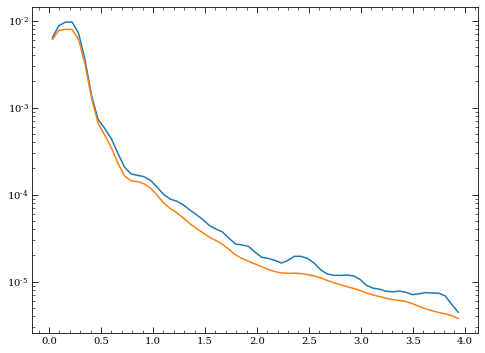

In [47]:
hdr = hdul1[0].header
rr, cont = do_contrast(hdul1[0].data, hdul2[0].data, hdr, supersample=False)
plt.semilogy(rr, cont)

rr, cont = do_contrast(psf1_over, psf2_over, hdr, supersample=False)
plt.semilogy(rr, cont)
#plt.ylim([1e-4,1e-2])

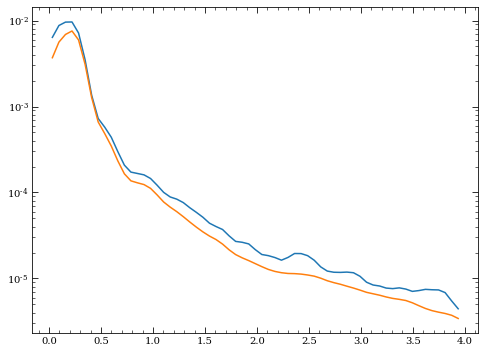

In [49]:
hdr = hdul1[0].header
rr, cont = do_contrast(hdul1[0].data, hdul2[0].data, hdr, supersample=False)
plt.semilogy(rr, cont)

rr, cont = do_contrast(psf1_over, psf2_over, hdr, supersample=False)
plt.semilogy(rr, cont)
#plt.ylim([1e-4,1e-2])

# Older Stuff

In [8]:
# SI Zernike data
data_dir = webbpsf.utils.get_webbpsf_data_path() + '/'
zernike_file = data_dir + 'si_zernikes_isim_cv3.fits'

# Read in table data
ztable_full = Table.read(zernike_file)

In [6]:
# PSF setup
filter = 'F405N'
kwargs = {}
kwargs['pupil'] = None #'CIRCLYOT'

kwargs['force']     = False
kwargs['save']      = True
kwargs['save_name'] = None

bp = read_filter(filter)
channel = 'SW' if bp.avgwave() < 24000 else 'LW'
module = kwargs.get('module', 'A') # If not specified, choose 'A'
kwargs['module'] = module
# Check if coronagraphy
pupil = kwargs.get('pupil', 'CLEAR') # If not specified, choose 'A'
kwargs['pupil'] = pupil

kwargs['detector'] = None
kwargs['detector_position'] = None
kwargs['include_si_wfe'] = True

kwargs['use_legendre'] = False
fov_pix = kwargs['fov_pix'] = 127
oversample = kwargs['oversample'] = 4

kwargs['opd'] = ('OPD_RevW_ote_for_NIRCam_requirements.fits.gz', 0)
kwargs['jitter'] = 'gaussian'
kwargs['jitter_sigma'] = 0.007

In [7]:
# SI Zernike data
if (pupil is not None) and ('LYOT' in pupil):
    zfile = 'si_zernikes_coron_wfe.fits'
else:
    zfile = 'si_zernikes_isim_cv3.fits'

data_dir = webbpsf.utils.get_webbpsf_data_path() + '/'
zernike_file = data_dir + zfile
ztable_full = Table.read(zernike_file)

mod = channel + module  
ind_nrc = ['NIRCam'+mod in row['instrument'] for row in ztable_full]  
ind_nrc = np.where(ind_nrc)

v2_all = np.array(ztable_full[ind_nrc]['V2'].tolist())
v3_all = np.array(ztable_full[ind_nrc]['V3'].tolist())

# Add detector corners
v2_min, v2_max, v3_min, v3_max = NIRCam_V2V3_limits(module, channel=channel, pupil=pupil, rederive=True, border=1)
igood = v3_all > v3_min
v2_all = np.append(v2_all[igood], [v2_min, v2_max, v2_min, v2_max])
v3_all = np.append(v3_all[igood], [v3_min, v3_min, v3_max, v3_max])


In [8]:
coeff0, cf_hdr = gen_psf_coeff(filter, **kwargs)

In [9]:
kwargs

{'pupil': None,
 'force': False,
 'save': True,
 'save_name': None,
 'module': 'A',
 'detector': None,
 'detector_position': None,
 'include_si_wfe': True,
 'use_legendre': False,
 'fov_pix': 127,
 'oversample': 4,
 'opd': ('OPD_RevW_ote_for_NIRCam_requirements.fits.gz', 0),
 'jitter': 'gaussian',
 'jitter_sigma': 0.007}

In [10]:
from pynrc.nrc_utils import field_coeff_resid
cf_fields, v2_all, v3_all = field_coeff_resid(filter, coeff0, return_raw=True, **kwargs)
# v2_corn, v3_corn = NIRCam_V2V3_limits(module, channel=channel, pupil=pupil, rederive=True, 
#                                       return_corners=True, border=0)

[     pynrc:WARNING] return_raw=True; Setting save=False, force=True
[     pynrc:WARNING] Generating field-dependent coefficients. This may take some time...
V2/V3 Coordinates and det pixel (sci) on NRCA5/NRCA5_FULL: (0.869207643, -8.776820281), (1561.1174212957687, 501.16111759180467)
[     pynrc:INFO] Generating but not saving new PSF coefficient
[     pynrc:INFO] Took 64.29 seconds to generate WebbPSF images
V2/V3 Coordinates and det pixel (sci) on NRCA5/NRCA5_FULL: (0.452795003, -8.389423768), (1957.8551491348626, 865.4842766560353)
[     pynrc:INFO] Generating but not saving new PSF coefficient
[     pynrc:INFO] Took 63.00 seconds to generate WebbPSF images
V2/V3 Coordinates and det pixel (sci) on NRCA5/NRCA5_FULL: (1.597543673, -9.219405725), (872.6147413098315, 83.06853207795746)
[     pynrc:INFO] Generating but not saving new PSF coefficient
[     pynrc:INFO] Took 88.02 seconds to generate WebbPSF images
V2/V3 Coordinates and det pixel (sci) on NRCA5/NRCA5_FULL: (2.403824824, -

In [9]:
pynrc.setup_logging('INFO')

pyNRC log messages of level INFO and above will be shown.
pyNRC log outputs will be directed to the screen.


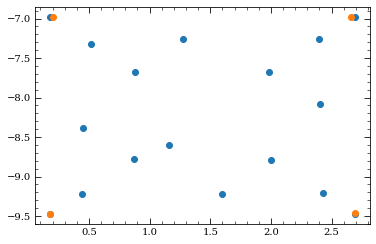

In [11]:
plt.plot(v2_all, v3_all, marker='o', ls='none')

v2_corn, v3_corn = NIRCam_V2V3_limits(module, channel=channel, pupil=pupil, rederive=True, return_corners=True, border=1)
plt.plot(v2_corn, v3_corn, marker='o', ls='none')

In [12]:
# Let's work with a single pixel and its coefficients to look at how it changes w.r.t. position
yind = xind = int(fov_pix*oversample / 2)    

# Create fine mesh grid
v2_min, v2_max = v2_all.min(), v2_all.max()
v3_min, v3_max = v3_all.min(), v3_all.max()

dstep = 1. / 60. # 1" steps
xgrid = np.arange(v2_min, v2_max+dstep, dstep)
ygrid = np.arange(v3_min, v3_max+dstep, dstep)

V2_interp, V3_interp = np.meshgrid(xgrid,ygrid)

#V2_interp = V2_interp.ravel()
#V3_interp = V3_interp.ravel()

cf_vals_one = cf_fields[:,:,0:5,0:5]
print(cf_fields.shape, cf_vals_one.shape, v2_all.shape, V2_interp.shape, cf_vals_one.shape)

(17, 11, 508, 508) (17, 11, 5, 5) (17,) (152, 152) (17, 11, 5, 5)


In [162]:
# ap = siaf['NRCA5_FULL']

# nvals = 1
# xvals = np.random.randint(0,2048,size=nvals)
# yvals = np.random.randint(0,2048,size=nvals)

# v2_new, v3_new = np.array(ap.sci_to_tel(xvals, yvals)) / 60

# isort = np.argsort(v2_new)
# v2_new = v2_new[isort]
# v3_new = v3_new[isort]

# cf_temp = cf_fields[:,0,:,:]#.reshape([17,-1,508,508])
# %time cf_grid = field_coeff_interp(v2_all, v3_all, cf_temp, v2_new, v3_new)
# print(cf_grid.shape)

CPU times: user 1.83 s, sys: 69.3 ms, total: 1.89 s
Wall time: 2.18 s
(10, 2, 508, 508)


In [36]:
cfnorm = np.abs(coeff0.reshape([11,-1]))
cfnorm = cfnorm / cfnorm.sum(axis=0)

cfstd = np.std(cfnorm, axis=1)
cfavg = np.mean(cfnorm, axis=1)

plt.semilogy(cfavg)
plt.plot(cfavg+cfstd)
plt.plot(cfavg-cfstd)

In [50]:
# Create an evenly spaced grid of V2/V3 coordinates
nv23 = 8
v2grid = np.linspace(v2_min, v2_max, num=nv23)
v3grid = np.linspace(v3_min, v3_max, num=nv23)

v2_new, v3_new = np.meshgrid(v2grid,v3grid)

sh = cf_fields.shape
cf_fields_grid = np.zeros([nv23,nv23,sh[1],sh[2],sh[3]])
# Cycle through each coefficient to interpolate onto V2/V3 grid
for i in range(sh[1]):
    print(i)
    cf_fields_grid[:,:,i,:,:] = griddata((v2_all, v3_all), cf_fields[:,i,:,:], (v2_new, v3_new), method='cubic')

0
1
2
3
4
5
6
7
8
9
10


In [55]:
print(cf_fields_grid.shape)
func = RegularGridInterpolator((v3grid, v2grid), cf_fields_grid[:,:,0,yind,xind], method='linear', bounds_error=False, fill_value=None)

pts = np.array([V3_interp, V2_interp]).transpose()
im_interp = func(pts).squeeze()

(8, 8, 11, 508, 508)


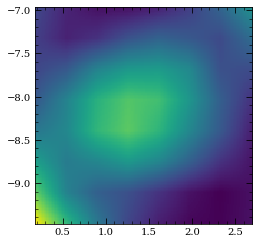

In [52]:
extent = np.array([V2_interp.min(), V2_interp.max(), V3_interp.min(), V3_interp.max()])
plt.imshow(im_interp, extent=extent)

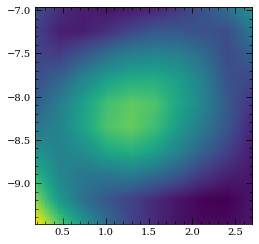

In [40]:
extent = np.array([V2_interp.min(), V2_interp.max(), V3_interp.min(), V3_interp.max()])
plt.imshow(im_interp, extent=extent)

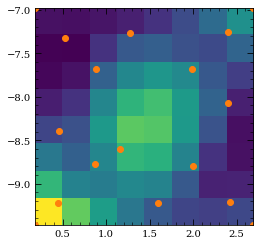

In [53]:
extent = [v2grid.min(),v2grid.max(),v3grid.min(),v3grid.max()]
plt.imshow(cf_fields_grid[:,:,0,yind,xind], extent=extent)
plt.plot(v2_all, v3_all, marker='o', ls='none', color='C1')

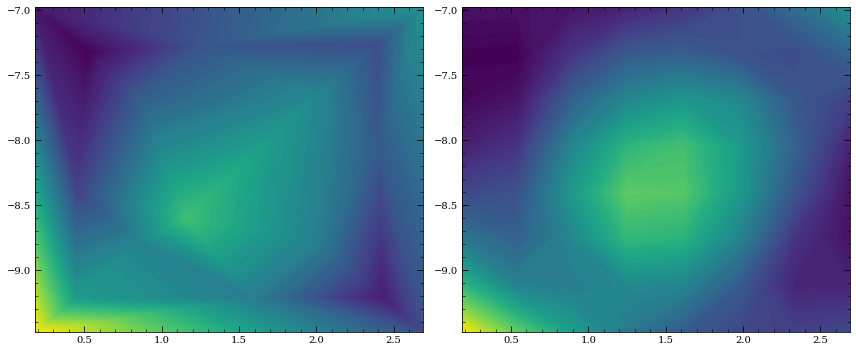

In [54]:
fig, axes = plt.subplots(1,2, figsize=(12,5))

axes[0].tricontourf(v2_all, v3_all, cf_fields[:,0,yind,xind], levels=100)
axes[1].contourf(v2grid, v3grid, cf_fields_grid[:,:,0,yind,xind], levels=100)

fig.tight_layout()

In [31]:
%time func = RegularGridInterpolator((v3grid, v2grid), cf_fields_grid, method='linear', bounds_error=False, fill_value=None)

CPU times: user 110 µs, sys: 1e+03 ns, total: 111 µs
Wall time: 115 µs


In [165]:
pts = np.array([V3_interp, V2_interp]).transpose()
pts.shape

(132, 132, 2)

In [184]:
v2 = np.array([0.5,1,1.5])
v3 = np.array([-9, -8, -7])

pts = np.array([v2,v3]).transpose()

In [185]:
%time test = func(pts).squeeze()

CPU times: user 190 ms, sys: 37.8 ms, total: 228 ms
Wall time: 475 ms


In [187]:
test2 = coeff0 + test

In [194]:
np.size([[5,2],[4,2]])

4

In [186]:
print(pts.shape,test.shape)

(3, 2) (3, 11, 508, 508)


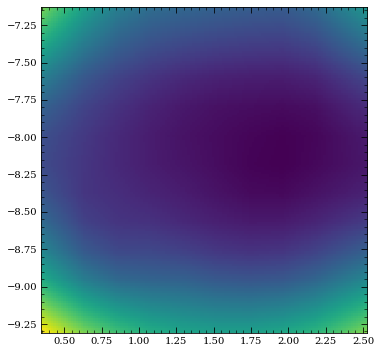

In [122]:
extent = np.array([V2_interp.min(), V2_interp.max(), V3_interp.min(), V3_interp.max()])
plt.imshow(test[:,:,0], extent=extent)

In [55]:
from scipy.interpolate import RectBivariateSpline, interp2d

In [74]:
# func = RectBivariateSpline(v3grid, v2grid, cf_grid[:,:,0,yind,xind])
func = interp2d(v2grid, v3grid, cf_grid[:,:,0,yind,xind], kind='cubic')

In [75]:
%time test = func(V2_interp[0,:].ravel(),V3_interp[:,0].ravel())

CPU times: user 1.36 ms, sys: 1.3 ms, total: 2.66 ms
Wall time: 1.99 ms


In [50]:
%time test = func(V3_interp[:,0].ravel(), V2_interp[0,:].ravel())

CPU times: user 763 µs, sys: 310 µs, total: 1.07 ms
Wall time: 851 µs


In [64]:
xt = [0,1,2];  yt = [0,3]; zt = np.array([[1,2,3], [4,5,6]])
zt.s

(2, 3)

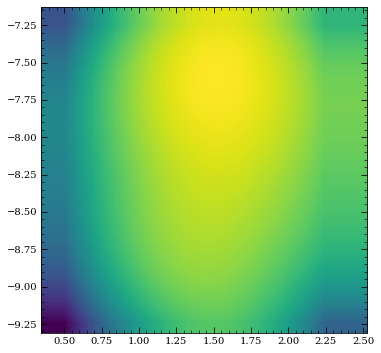

In [76]:
plt.imshow(test, extent=extent)

In [64]:
cf_temp = cf_fields.reshape([17,11,-1])
%time cf_grid = griddata((v2_all, v3_all), cf_temp, (V2_interp[0:100],V3_interp[0:100]), method='cubic')
print(cf_grid.shape)

CPU times: user 6.73 s, sys: 1.46 s, total: 8.19 s
Wall time: 8.7 s
(100, 11, 258064)


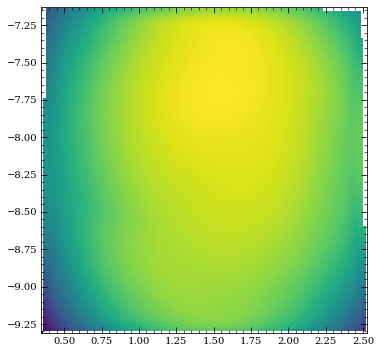

In [13]:
extent = np.array([xgrid.min(),xgrid.max(),ygrid.min(),ygrid.max()])
plt.imshow(cf_grid[:,:,0], extent=extent)

In [ ]:
# Work 

In [14]:
# least squares estimation
# X*A = Z
X = v2_all
Y = v3_all
x_fl = X.flatten().reshape([X.size, 1])
y_fl = Y.flatten().reshape([Y.size, 1])
z_ones = np.ones([X.size,1])
XX = np.hstack((x_fl**2, y_fl**2, x_fl, y_fl, z_ones))


In [15]:
Z = cf_fields.ravel()
Z = Z.reshape([X.size,-1])
#A_lsq = np.linalg.lstsq(XX,Z)[0]
q, r = np.linalg.qr(XX, 'reduced')
qTb = np.dot(q.T, Z)
A_lsq = np.linalg.lstsq(r, qTb)[0]
A_lsq = A_lsq.reshape([-1, coeff0.shape[0], coeff0.shape[1], coeff0.shape[2]])


In [110]:
print(A_lsq.shape, cf_fields.shape)

(5, 11, 508, 508) (17, 11, 508, 508)


In [16]:
from pynrc import nrc_utils
A_reshape = A_lsq[:,:,yind,xind].reshape([5,11,1,1])
test1 = field_model(V2_interp, V3_interp, A_reshape, calc_legpoly=False)

#diff1 = cf_fields - test1
#print(diff1.min(), diff1.max())

In [17]:
cf_grid2 = test1.reshape([132,132,-1])

In [27]:
ind_nan = np.isnan(cf_grid)
cf_grid[ind_nan] = cf_grid2[ind_nan]
diff = cf_grid - cf_grid2

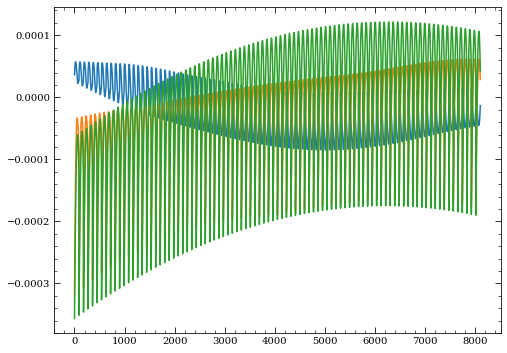

In [32]:
plt.plot(diff[10:100,10:100,0].flatten())
plt.plot(cf_grid[10:100,10:100,0].flatten())
plt.plot(cf_grid2[10:100,10:100,0].flatten())

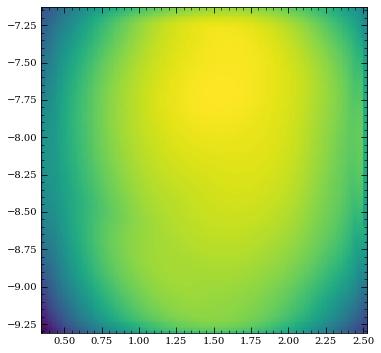

In [26]:
extent = np.array([xgrid.min(),xgrid.max(),ygrid.min(),ygrid.max()])
plt.imshow(cf_grid[:,:,0], extent=extent)